## Importing required libraries

In [1]:
# !python3 -m pip install --upgrade pip
# !pip3 install torch
# !pip install transformers
# !pip install tensorflow-gpu
# !pip install sentencepiece
# !pip3 install matplotlib
# !pip3 install transformers==2.9.0 
# !pip3 install pytorch_lightning==0.7.5

import sentencepiece

import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
import re
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

import torch
if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

## Loading the processed data 

In [7]:
# train_df=pd.read_csv('webNLG2020_train.csv', index_col=[0])



# train_df=pd.read_csv('ad_atypical.csv', index_col=0)
# train_df=pd.read_csv('ad_atypical.csv', index_col=0)
# train_df=pd.read_csv('ad_atypical_aug2.csv', index_col=0)
train_df=pd.read_csv('aty.csv', index_col=0)
# train_df=pd.read_csv('unsupervised.csv', index_col=0)
batch_size=8
num_of_batches=len(train_df)/batch_size
num_of_epochs=1
num_of_batches=int(num_of_batches)
print(batch_size, num_of_batches, num_of_epochs)

# print(type(train_df.iloc[0]['obj2']))
# train_df['obj1'] = train_df['obj1'].astype(str)
# train_df['obj2'] = train_df['obj2'].astype(str)
# train_df = train_df.fillna('')
# print(type(train_df.iloc[0]['obj2']))

train_df

8 1775 1


,Id,QA,Atypical_Annot,Aty,method,obj1,obj2,Atypical_Annot2
0,110991.jpg,I should eat Oreos because I can snack on Oreo...,Liquid Deformed Object: The liquid which has b...,milk,Liquid Deformed Object,milk,NaN,Liquid Deformed Object: The liquid which has b...
1,110991.jpg,I should eat Oreos because I can snack on Oreo...,Liquid Deformed Object: The liquid which has b...,milk,Liquid Deformed Object,milk,NaN,Liquid Deformed Object: The liquid which has b...
2,110991.jpg,I should eat Oreos because I can snack on Oreo...,Object Replacement: The object which is placed...,cookie milk person body hoopnet,Object Replacement,cookie- milk,person- body- hoop/net,Object Replacement: The object which is placed...
3,110991.jpg,I should eat Oreo's because Oreo fun to dunk O...,Liquid Deformed Object: The liquid which has b...,milk,Liquid Deformed Object,milk,NaN,Liquid Deformed Object: The liquid which has b...
4,110991.jpg,I should eat Oreo's because Oreo fun to dunk O...,Liquid Deformed Object: The liquid which has b...,milk,Liquid Deformed Object,milk,NaN,Liquid Deformed Object: The liquid which has b...
...,...,...,...,...,...,...,...,...
14202,102221.jpg,I should buy Oreo cookies because Oreo cookies...,Object Replacement: The object which is placed...,oreo persons head,Object Replacement,oreo,person's head,Object Replacement: The object which is placed...
14203,102221.jpg,I should buy oreo cookies because when you eat...,Object with Missing Part: The objects which ha...,person,Object with Missing Part,person,NaN,Object with Missing Part: The objects which ha...
14204,102221.jpg,I should buy oreo cookies because when you eat...,Solid Deformed Object: The objects that have b...,a persons body tornado,Solid Deformed Object,a persons body,tornado,Solid Deformed Object: The objects that have b...
14205,102221.jpg,I should buy oreo cookies because when you eat...,Solid Deformed Object: The objects that have b...,person twisted,Solid Deformed Object,person,twisted,Solid Deformed Object: The objects that have b...


In [54]:
# new =[]
# for i in range(len(train_df)):
#     temp = train_df.iloc[i]['Atypical_Annot'].replace('<b>', '')
#     new.append(temp.replace('</b>', ''))
# train_df['Atypical_Annot2'] =new
# train_df
# train_df.to_csv('aty.csv')

In [5]:
# s = re.sub(r'[^\w\s]','',train_df.iloc[2]['Aty'])
# s
# aty2=[]
# for ind, row in train_df.iterrows():
#     aty2.append( re.sub(r'[^\w\s]','',train_df.iloc[ind]['Aty']))
# train_df['Aty2'] = aty2
# train_df

In [6]:

train_df = train_df[7709:]
train_df

,Id,QA,Atypical_Annot,Aty,method,obj1,obj2
7709,144890.jpg,I should wear Nike because this is what athlet...,Texture Replacement 2: The object which has a ...,body words,Texture Replacement 2,body,words
7710,144890.jpg,I should wear Nike because this is what athlet...,Object Replacement: The object which is placed...,text as clothes clothes,Object Replacement,text as clothes,clothes
7711,144890.jpg,I should buy nike brand because all these famo...,Texture Replacement 1: The object which has a ...,player player,Texture Replacement 1,player,player
7712,144890.jpg,I should buy nike brand because all these famo...,Texture Replacement 2: The object which has a ...,body words,Texture Replacement 2,body,words
7713,144890.jpg,I should buy nike brand because all these famo...,Object Replacement: The object which is placed...,text as clothes clothes,Object Replacement,text as clothes,clothes
...,...,...,...,...,...,...,...
14202,102221.jpg,I should buy Oreo cookies because Oreo cookies...,Object Replacement: The object which is placed...,oreo persons head,Object Replacement,oreo,person's head
14203,102221.jpg,I should buy oreo cookies because when you eat...,Object with Missing Part: The objects which ha...,person,Object with Missing Part,person,NaN
14204,102221.jpg,I should buy oreo cookies because when you eat...,Solid Deformed Object: The objects that have b...,a persons body tornado,Solid Deformed Object,a persons body,tornado
14205,102221.jpg,I should buy oreo cookies because when you eat...,Solid Deformed Object: The objects that have b...,person twisted,Solid Deformed Object,person,twisted


In [7]:
# # !pip3 install spacy
# import spacy
# nlp = spacy.load('en_core_web_sm')



## unsupervised

In [8]:
# # noisey data:
# # n=121
# # a = [tag[3:-4].lower() for tag in re.findall('<b>.{2,30}</b>', row['output'])]

# i=0
# for ind,row in train_df.iterrows():
#     l = len(re.split('because', row['input']))
#     if l>2:
#         i+=1
# #         print(l,'\n',row['QA'])
# i

In [9]:
# method=[]
# obj1=[]
# obj2=[]

# for ind,row in train_df.iterrows():
#     method.append(row['Atypical_Annot'].split(':')[0])
#     a = [tag[3:-4].lower() for tag in re.findall('<b>.{2,30}</b>', row['Atypical_Annot'])]
#     try:
#         obj1.append(a[0])
#     except:
#         obj1.append('')
#     try:
#         obj2.append(a[1])
#     except:
#         obj2.append('')
            
# train_df['method'] = method
# train_df['obj1'] = obj1
# train_df['obj2'] = obj2
# train_df


In [10]:
s = 'I should use Neutrogena Deep Clean Because Neutrogena Deep Clean Because will make my skin more youthful and clean.'
s = 'I should use Neutrogena Deep Clean Because Neutrogena Deep Clean Because will make my skin more youthful and clean.'
print(s)
print(re.sub('Because.*Because', 'because', s))

I should use Neutrogena Deep Clean Because Neutrogena Deep Clean Because will make my skin more youthful and clean.
I should use Neutrogena Deep Clean because will make my skin more youthful and clean.


In [11]:
# print((train_df.iloc[0]['QA']), "\n\n", train_df.iloc[0]['Atypical_Annot'])
i=0
Q=[]
R=[]
for ind,row in train_df.iterrows():
#     print(len([sen[1:-1]  for sen in row['QA'][1:-1].split(',')]),[sen[1:-1]  for sen in row['QA'][1:-1].split(',')], "\n")
#     print(len([sen[1:-1]  for sen in row['Atypical_Annot'][1:-1].split(',')]),[sen[1:-1]  for sen in row['Atypical_Annot'][1:-1].split(',')], "\n")

    
    
    
    for q in [sen  for sen in row['QA'][1:-1].split(',')]:
        for r in [sen  for sen in row['Atypical_Annot'][1:-1].split(',')]:
            r = r.replace('<b>','')
            r = r.replace('</b>','')
#             print(q,'\n',r)
#             print("***")
            Q.append(q)
            R.append(r)

#     print("____________")

#     i+=1
#     if i==3:
#         break
#     break
print(len(Q),len(R))
train_df = pd.DataFrame(data = {'QA':Q, 'Atypical_Annot':R})
train_df

6760 6760


,QA,Atypical_Annot
0,should wear Nike because this is what athlete...,exture Replacement 2: The object which has a n...
1,should wear Nike because this is what athlete...,bject Replacement: The object which is placed ...
2,should buy nike brand because all these famou...,exture Replacement 1: The object which has a n...
3,which means I should too,exture Replacement 1: The object which has a n...
4,should buy nike brand because all these famou...,exture Replacement 2: The object which has a n...
...,...,...
6755,should buy Oreo cookies because Oreo cookies ...,bject Replacement: The object which is placed ...
6756,should buy oreo cookies because when you eat ...,bject with Missing Part: The objects which hav...
6757,should buy oreo cookies because when you eat ...,olid Deformed Object: The objects that have be...
6758,should buy oreo cookies because when you eat ...,olid Deformed Object: The objects that have be...


Trimming off a few data points and so that a batch would not leave any remainder, hence some lines of codes can be avoided (Okay, this might be a hackish way of doing it )

Checking for the GPU availability

In [3]:

import transformers
print(transformers.__version__)


# !pip3 install tensorflow
import tensorflow
print(tensorflow.__version__)


import torch
print(torch.__version__)


import torch
if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")
    
print( torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
import tensorflow as tf
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


4.8.2
2.6.0
1.9.0+cu102
Running on the GPU
cuda:0
/device:GPU:0
Num GPUs Available:  1


## Loading the pretrained model and tokenizer

In [3]:
# !pip install transformers==2.9.0 
# !pip install pytorch_lightning==0.7.5
# !pip install sentencepiece
import sentencepiece
tokenizer = T5Tokenizer.from_pretrained('t5-small', local_files_only=True)
model = T5ForConditionalGeneration.from_pretrained('t5-small', local_files_only=True)#, return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)
print(type(tokenizer))

<class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>


In [4]:
# !pip install transformers==2.9.0 
# !pip install pytorch_lightning==0.7.5
# !pip install sentencepiece
import sentencepiece
# tokenizer = T5Tokenizer.from_pretrained('t5-base')#, local_files_only=True)
# tokenizer = T5Tokenizer.from_pretrained('t5-small', local_files_only=True)

model = T5ForConditionalGeneration.from_pretrained('t5-base', local_files_only=True)#, return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)
print(type(tokenizer))

<class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>


## Initializing the Adafactor optimizer with parameter values suggested for t5

In [9]:

optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,#1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)
# ------------------------------------------------------------    
batch_size=2
num_of_batches=len(train_df)/batch_size
num_of_epochs=1
num_of_batches=int(num_of_batches)
print(batch_size, num_of_batches, num_of_epochs)
# ------------------------------------------------------------    
from IPython.display import HTML, display
def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))


2 7103 1


## Training the model

In [ ]:
#Sets the module in training mode
# tokenizer = T5Tokenizer.from_pretrained('t5-small', local_files_only=True)
model = T5ForConditionalGeneration.from_pretrained('t5-small', local_files_only=True)#, return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

model.train()
model.to(dev)
num_of_epochs=3

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
        
#       # unsupervised:
#       input = row['input'][:512]
#       labels = row['output'][:512]
        # supervised:
      input = row['QA'][:511]+' </s>' 
      labels = row['Atypical_Annot2'][:511]+' </s>'
      

#       input = 'QA: '+row['QA'][:511]+'</s>' 
#       labels = '<b>'+ row['Aty'][1:-1] +'</b>'


#       t = row['Atypical_Annot'][:511].replace("<b>","")
#       t = t.replace('</b>','')
#       labels = t+'</s>'   
#       labels = row['Atypical_Annot'][:511]+'</s>'
#       labels = '<b>'+ row['Aty'][1:-1] +'</b>'
#       input = 'WebNLG: '+row['input_text']+'</s>' 
#       labels = row['target_text']+'</s>'   
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,pad_to_max_length=True,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,pad_to_max_length=True,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
    
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))


Running epoch: 1


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
def train_model(inputdata, pretrain,file_name,key_in, key_out, n_epochs):
    tokenizer = T5Tokenizer.from_pretrained('t5-small', local_files_only=True)
    model = T5ForConditionalGeneration.from_pretrained(pretrain, local_files_only=True)#, return_dict=True)
    model.to(dev)
    
    model.train()
    num_of_epochs=n_epochs
    train_df = pd.read_csv(inputdata)
    train_df = train_df.fillna('')


    loss_per_10_steps=[]
    for epoch in range(1,num_of_epochs+1):
        print('Running epoch: {}'.format(epoch))

        running_loss=0

        out = display(progress(1, num_of_batches+1), display_id=True)
        for i in range(num_of_batches):
            inputbatch=[]
            labelbatch=[]
            new_df=train_df[i*batch_size:i*batch_size+batch_size]
            for indx,row in new_df.iterrows():
                #pre processing:
                input = row[key_in][:511]+'</s>' 
                labels = row[key_out][:511]+'</s>'
                
                inputbatch.append(input)
                labelbatch.append(labels)
            if not inputbatch:
                break
            inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,pad_to_max_length=True,return_tensors='pt')["input_ids"]
            labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,pad_to_max_length=True,return_tensors="pt") ["input_ids"]
            inputbatch=inputbatch.to(dev)
            labelbatch=labelbatch.to(dev)

            # clear out the gradients of all Variables 
            optimizer.zero_grad()

            # Forward propogation
            outputs = model(input_ids=inputbatch, labels=labelbatch)
            loss = outputs.loss
            loss_num=loss.item()
            logits = outputs.logits
            running_loss+=loss_num
            if i%10 ==0:      
                loss_per_10_steps.append(loss_num)
            out.update(progress(loss_num,i, num_of_batches+1))

            # calculating the gradients
            loss.backward()

            #updating the params
            optimizer.step()

        running_loss=running_loss/int(num_of_batches)
        print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
        

        
    #show plt
    steps = [i*100 for i in range(len(loss_per_10_steps))]
    plt.plot(steps, loss_per_10_steps)
    plt.title('Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.show()
    plt.savefig(file_name+'.png')
    
    #save model
    model.save_pretrained(file_name+".h5")
    
    return model




In [ ]:
# train all them in one model!
####def train_model(inputdata, pretrain,file_name,key_in, key_out, n_epochs):

# high loss shows it's not learn able
# no difference between 1 or 5 epochs:
# model1 = train_model('aty.csv','t5-small','t5_step9_b1_27_8_2021','Atypical_Annot', 'Aty2', 5) 


# not converging too. nor for 1 or 5 epochs
# model2 = train_model('unsupervised.csv','t5_step9_b1_27_8_2021.h5','t5_step9_b2_27_8_2021','input', 'output', 5)


# not converging too. nor for 1 or 5 epochs
model3 = train_model('aty.csv','t5-small','t5_step9_b3_27_8_2021','QA', 'Atypical_Annot', 5)


In [ ]:

# not converging too. nor for 1 or 5 epochs
model2 = train_model('unsupervised.csv','t5-small','t5_step9_b3_27_8_2021','input', 'output', 20)



Running epoch: 1


In [ ]:

# not converging too. nor for 1 or 5 epochs
model3 = train_model('aty.csv','t5_step9_b3_27_8_2021.h5','t5_step9_b3_27_8_2021','QA', 'Atypical_Annot', 20)


In [6]:
model3 = train_model('aty.csv','t5-small','t5_step10_3_9_2021','Atypical_Annot', 'obj2', 20)
# model4 = train_model('aty.csv','t5_step10_3_9_2021.h5','t5_step10_3_9_2021','Atypical_Annot', 'obj1', 1)
# model4 = train_model('aty.csv','t5_step10_3_9_2021.h5','t5_step10_3_9_2021','Atypical_Annot', 'obj2', 1)


Running epoch: 1


Epoch: 1 , Running loss: 9.485981562171183
Running epoch: 2


Epoch: 2 , Running loss: 9.527599294017739
Running epoch: 3


Epoch: 3 , Running loss: 9.441954496141891
Running epoch: 4


Epoch: 4 , Running loss: 9.547300226184683
Running epoch: 5


Epoch: 5 , Running loss: 9.543375372147896
Running epoch: 6


Epoch: 6 , Running loss: 9.501141243383918
Running epoch: 7


Epoch: 7 , Running loss: 9.466414746969518
Running epoch: 8


Epoch: 8 , Running loss: 9.474585341466984
Running epoch: 9


Epoch: 9 , Running loss: 9.496275417703977
Running epoch: 10


Epoch: 10 , Running loss: 9.497935727750752
Running epoch: 11


KeyboardInterrupt: 

In [43]:
i=100
model.save_pretrained('t5_step10_3_9_2021'+".h5")

sengen_supervised('t5_step10_3_9_2021.h5',train_df,'QA', 'Atypical_Annot',i,tokenizer)


input: 
 I should watch what I eat because I order take out alot. 
Texture Replacement 2: The object which has a new texture is <b>bottle</b> and the objects that have created the texture are <b>forks- chocolate- food</b>

pred: [' Object Inside Object: Objects which are inside are <unk> b>woman<unk>'] 
out: ['Texture Replacement 2: The object which has a new texture is <b>bottle</b> and the objects that have created the texture are <b>forks- chocolate- food</b>']
________________________


In [43]:
re.sub(' +', ' ','')

''

In [ ]:
train_df = pd.read_csv('unsupervised.csv', index_col=0)
train_df
for ind,row in train_df.iterrows():
    if len(row['input'])<3 or len(row['output'])<3:
        print(row['input'], row['output'])

## Plotting the loss over time

In [ ]:
#1: 1 epoch
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

In [ ]:
#2: 10 epoch
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

In [ ]:
#3: 1 epoch with out <b> tag
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

In [ ]:
#4: 1 epoch with out <b> tag and tarkib each Q and A (14730 rows )
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

In [25]:
#5: 10 epoch with ad_atypical_aug.csv (just tarkib & co-ref)
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

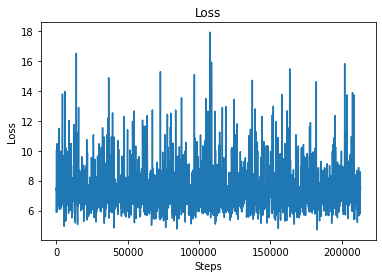

In [22]:
#8: 4 epoch - unsupervised - 11k rows - 25-8-2021
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

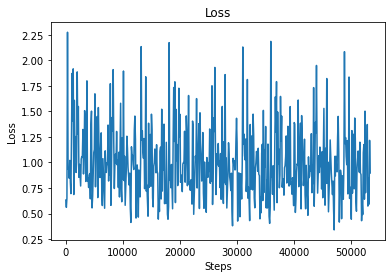

In [13]:
#8: 4 epoch - supervised - 14k rows - 25-8-2021
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

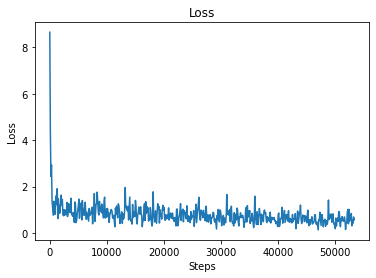

In [6]:
#9: 4 epoch - unsupervised - 3k rows - 26-8-2021 - [7709:](just Annot)
# model.save_pretrained("t5_step9_26_8_2021.h5")
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

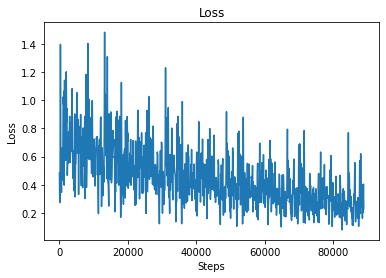

In [42]:
#9: 1 epoch - unsupervised - 
# model.save_pretrained("t5_step9_26_8_2021.h5")
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

## Testing the model

In [ ]:
model.eval()
# input_ids = tokenizer.encode("WebNLG: sidharth | hometown | Delhi && sidharth | play |  football </s>", return_tensors="pt")  # Batch size 1
print('QA: '+new_df.iloc[-1]['QA']+'</s>', '\n')
input_ids = tokenizer.encode('QA: '+new_df.iloc[-1]['QA']+'</s>', return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]),'\n\n', new_df.iloc[-1]['Atypical_Annot']+'</s>')

In [ ]:
model.eval()
# input_ids = tokenizer.encode("WebNLG: sidharth | hometown | Delhi && sidharth | play |  football </s>", return_tensors="pt")  # Batch size 1
print('QA: '+train_df.iloc[-1]['QA']+'</s>', '\n')
input_ids = tokenizer.encode('QA: '+ train_df.iloc[-1]['QA']+'</s>', return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]),'\n\n', train_df.iloc[-1]['Atypical_Annot']+'</s>')

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small', local_files_only=True)

model = T5ForConditionalGeneration.from_pretrained('t5_step6_18_8_2021.h5')
model
model.eval()
# input_ids = tokenizer.encode("WebNLG: sidharth | hometown | Delhi && sidharth | play |  football </s>", return_tensors="pt")  # Batch size 1
print('QA: '+train_df.iloc[-1]['QA']+'</s>', '\n')
input_ids = tokenizer.encode('QA: '+ train_df.iloc[-1]['QA']+'</s>', return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]),'\n\n', train_df.iloc[-1]['Atypical_Annot']+'</s>')

model = T5ForConditionalGeneration.from_pretrained('t5_step7_18_8_2021.h5')
model.eval()
# input_ids = tokenizer.encode("WebNLG: sidharth | hometown | Delhi && sidharth | play |  football </s>", return_tensors="pt")  # Batch size 1
input_ids = tokenizer.encode('QA: '+ train_df.iloc[-1]['QA']+'</s>', return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]))


In [ ]:
# step 8
t =-1
# model.save_pretrained("t5_step8_25_8_2021.h5")
# tokenizer = T5Tokenizer.from_pretrained('t5-small', local_files_only=True)
el = T5ForConditionalGeneration.from_pretrained('t5_step8_25_8_2021.h5', local_files_only=True)
model.eval()
input_ids = tokenizer.encode(train_df.iloc[0]['input'], return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
print(train_df.iloc[0]['input'])
print(tokenizer.decode(outputs[0]))
print(train_df.iloc[0]['output'])



In [ ]:
# step 8
t =-1
model.eval()
# input_ids = tokenizer.encode("WebNLG: sidharth | hometown | Delhi && sidharth | play |  football </s>", return_tensors="pt")  # Batch size 1
print('QA: '+train_df.iloc[t]['QA']+'</s>', '\n')
input_ids = tokenizer.encode('QA: '+ train_df.iloc[t]['QA']+'</s>', return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]),'\n\n', train_df.iloc[t]['Atypical_Annot']+'</s>')


In [ ]:
# The main model t5-small
t =-1
model.eval()
# input_ids = tokenizer.encode("WebNLG: sidharth | hometown | Delhi && sidharth | play |  football </s>", return_tensors="pt")  # Batch size 1
print('QA: '+train_df.iloc[t]['input'], '\n')
input_ids = tokenizer.encode(train_df.iloc[t]['input'], return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]),'\n\n', train_df.iloc[t]['output']+'</s>')


In [ ]:
# just 1 epoch for unsupervised
## much bettr than 4 epoch
t =-1
model.eval()
# input_ids = tokenizer.encode("WebNLG: sidharth | hometown | Delhi && sidharth | play |  football </s>", return_tensors="pt")  # Batch size 1
print(train_df.iloc[t]['input'], '\n')
input_ids = tokenizer.encode(train_df.iloc[t]['input'], return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]),'\n\n', train_df.iloc[t]['output']+'</s>')


In [5]:
# unsupervised
def sengen_unsupervised(model_path,train_df,t, tokenizer):
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    model.eval()
    input_ids = tokenizer.encode(train_df.iloc[t]['input'], return_tensors="pt")  # Batch size 1
    input_ids=input_ids.to(dev)
    model = model.to(dev)
    outputs = model.generate(input_ids)
    
    print('input: \n', train_df.iloc[t]['input'])
    
    pred = tokenizer.decode(outputs[0])
    pred = re.sub('<pad>', '',pred)
#     pred = re.sub('<b>', '',pred)
#     pred = re.sub('</b>', '',pred)
    pred = re.sub('</s>', '',pred)
    pred = re.sub(' +', ' ',pred)
    pred = re.compile(r'<extra_id_\d*>').split(pred)
    
    out = train_df.iloc[t]['output']
    out = re.sub(' +', ' ',out)
    out = re.compile(r'<extra_id_\d*>').split(out)
    
    print('\npred:',pred,'\nout:',out)
    print("________________________")
    

#     return pd.DataFrame([pred,out], columns=['pred', 'out'])
# tokenizer = T5Tokenizer.from_pretrained('t5-small', local_files_only=True)
train_df=pd.read_csv('unsupervised.csv', index_col=0)

for i in [-1,10,100,1000]:
    print('\nt5_step8_25_8_2021', '4 epoch - unsupervised')
    sengen_unsupervised('t5_step8_25_8_2021.h5',train_df,i,tokenizer)
    
    
    print('\nt5_step9_26_8_2021', '4 epoch - unsuperviesd - [7709:](just Annot)')
    sengen_unsupervised('t5_step9_26_8_2021.h5',train_df,i,tokenizer)

    print('\nt5_step9_27_8_2021', '1 epoch - unsuperviesd')
    sengen_unsupervised('t5_step9_27_8_2021.h5',train_df,i,tokenizer)
    
    print('\nt5_step9_b3_27_8_2021_1', '50 epoch - unsuperviesd- input>output')
    sengen_unsupervised('t5_step9_b3_27_8_2021_1.h5',train_df,i,tokenizer)
    
    print('\nt5_step9_15_9_2021', '50 epoch - unsuperviesd- input>output--t5-base')
    sengen_unsupervised('t5_step9_15_9_2021.h5',train_df,i,tokenizer)
    
    
    
    print("==================================")
# sengen('t5_step8_25_8_2021.h5',train_df,i,tokenizer)



t5_step8_25_8_2021 4 epoch - unsupervised
input: 
 <extra_id_0>: The object which is placed in the context of another object is <extra_id_1> and the object which is replaced by another object (expected object) <extra_id_2>

pred: [' ', ' Object Replacement', ' ice', ' ice', ' '] 
out: ['', ' Object Replacement ', ' oreo ', " person's head ", '']
________________________

t5_step9_26_8_2021 4 epoch - unsuperviesd - [7709:](just Annot)
input: 
 <extra_id_0>: The object which is placed in the context of another object is <extra_id_1> and the object which is replaced by another object (expected object) <extra_id_2>

pred: [' Object Inside Object: Objects which are inside are object and the objects that are'] 
out: ['', ' Object Replacement ', ' oreo ', " person's head ", '']
________________________

t5_step9_27_8_2021 1 epoch - unsuperviesd
input: 
 <extra_id_0>: The object which is placed in the context of another object is <extra_id_1> and the object which is replaced by another object

In [6]:
#supervised
def sengen_supervised(model_path,train_df, key_in, key_out,t, tokenizer):
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    model.eval()
    input_ids = tokenizer.encode(train_df.iloc[t][key_in]+' </s>',padding=True,pad_to_max_length=True, return_tensors="pt")  # Batch size 1
    input_ids=input_ids.to(dev)
    model = model.to(dev)
    outputs = model.generate(input_ids)
    
    print('input: \n', train_df.iloc[t][key_in])
    
    pred = tokenizer.decode(outputs[0])
    pred = re.sub('<pad>', '',pred)
#     pred = re.sub('<b>', '',pred)
#     pred = re.sub('</b>', '',pred)
    pred = re.sub('</s>', '',pred)
    pred = re.sub(' +', ' ',pred)
    pred = re.compile(r'<extra_id_\d*>').split(pred)
    
    
    
    out = train_df.iloc[t][key_out]
    print(out)
    out = re.sub(' +', ' ',out)
    out = re.compile(r'<extra_id_\d*>').split(out)
    
    print('\npred:',pred,'\nout:',out)
    print("________________________")
train_df=pd.read_csv('aty.csv', index_col=0)

for i in [-1,10,100,1000]:
    print('\nt5_step5_16_8_2021', '10 epoch - ')
    sengen_supervised('t5_step5_16_8_2021.h5',train_df,'QA','Atypical_Annot2', i,tokenizer)
    
    print('\nt5_step6_18_8_2021', '10 epoch - ')
    sengen_supervised('t5_step6_18_8_2021.h5',train_df,'QA','Atypical_Annot2',i,tokenizer)
    
    print('\nt5_step7_18_8_2021', '10 epoch - ')
    sengen_supervised('t5_step7_18_8_2021.h5',train_df,'QA','Atypical_Annot2',i,tokenizer)
    
    print('\nt5_step8-2_25_8_2021', '10 epoch - ')
    sengen_supervised('t5_step8-2_25_8_2021.h5',train_df,'QA','Atypical_Annot2',i,tokenizer)

    print('\nt5_step10_3_9_2021', '1 epoch - ')
    sengen_supervised('t5_step10_3_9_2021.h5',train_df, 'QA','Atypical_Annot2',i,tokenizer)

    print('\nt5_step9_b3_27_8_2021', '20 epoch on input>output unserpvised -- 20 epochs on QA>Atypicla ')
    sengen_supervised('t5_step9_b3_27_8_2021.h5',train_df, 'QA','Atypical_Annot2',i,tokenizer)
    
    print('\nt5_step9_b3_27_8_2021_2', '50 epoch on input>output unserpvised -then- 50 epochs on QA>Atypicla ')
    sengen_supervised('t5_step9_b3_27_8_2021.h5',train_df, 'QA','Atypical_Annot2',i,tokenizer)
    
    print('\nt5_step9_15_9_20212', '50 epoch on input>output unserpvised -then- 50 epochs on QA>Atypicla , t5--base')
    sengen_supervised('t5_step9_15_9_20212.h5',train_df, 'QA','Atypical_Annot2',i,tokenizer)
    
    
    
    print("==================================")
# sengen('t5_step8_25_8_2021.h5',train_df,i,tokenizer)



t5_step5_16_8_2021 10 epoch - 
input: 
 I should buy oreo cookies because when you eat oreo cookies your world gets filled with wonder.
Object Replacement: The object which is placed in the context of another object is oreo and the object which is replaced by another object (expected object) person's head

pred: [' Object Replacement: The object which is placed in the context of another object is <unk> b'] 
out: ["Object Replacement: The object which is placed in the context of another object is oreo and the object which is replaced by another object (expected object) person's head"]
________________________

t5_step6_18_8_2021 10 epoch - 
input: 
 I should buy oreo cookies because when you eat oreo cookies your world gets filled with wonder.
Object Replacement: The object which is placed in the context of another object is oreo and the object which is replaced by another object (expected object) person's head

pred: [' <unk> b>\'oreo\', "person\'s head"<unk> /b'] 
out: ["Object Repla

input: 
 I should use Addiosn Lee because they will get me to work safely and calmly
Object Inside Object: Objects which are inside are people and the objects that are outside are bubble

pred: [' Object Inside Object: Objects which are inside are man and the objects that are'] 
out: ['Object Inside Object: Objects which are inside are people and the objects that are outside are bubble']
________________________

t5_step5_16_8_2021 10 epoch - 
input: 
 I should watch what I eat because I order take out alot. 
Texture Replacement 2: The object which has a new texture is bottle and the objects that have created the texture are forks- chocolate- food

pred: [' Object Replacement: The object which is placed in the context of another object is <unk> b'] 
out: ['Texture Replacement 2: The object which has a new texture is bottle and the objects that have created the texture are forks- chocolate- food']
________________________

t5_step6_18_8_2021 10 epoch - 
input: 
 I should watch what I ea

In [8]:
train_df.iloc[1000]['QA'], train_df.iloc[1000]['Atypical_Annot']

('I should buy a Nissan Leaf because the Nissan Leaf is eco-friendly. ',
 'Combination of Parts: The objects that have created new object are <b>leaf- road map</b>')

In [ ]:
# print('\x1b[1;31m'+'Hello world'+'\x1b[0m')


In [ ]:
# model = train_model(pretrain,file_name,key_in, key_out, n_epochs)
model = train_model('t5-small','t5_step9_b_27_8_2021',key_in, key_out, 1)